<a href="https://colab.research.google.com/github/INmais/reliable/blob/master/Sentinel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Satellite Imagery

### Data

Entity: ESA

url: https://scihub.copernicus.eu/dhus/#/home

SENTINEL-2 is a European wide-swath, high-resolution, multi-spectral imaging mission. The full mission specification of the twin satellites flying in the same orbit but phased at 180°, is designed to give a high revisit frequency of 5 days at the Equator.

![alt text](https://earth.esa.int/image/image_gallery?uuid=c5fa6c3e-2978-4fb8-ac95-3be9c5171be2&groupId=247904&t=1345630320883)

souce: https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial


### Bands
![alt text](https://s3.amazonaws.com/content.satimagingcorp.com/media/cms_page_media/1530/image001.png)

Install needed libraries (others are are installed in Colab)

In [0]:
! pip install sentinelsat
! pip install geopandas
! pip install rasterio

In [0]:
#import required libraries

#base
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#to get and read Sentinel 2 data
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 

#dealing with GIS and shapes
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import fiona

#maps
import folium

#images
import rasterio as rio
from rasterio.plot import show
from rasterio import plot
import rasterio.mask

Set new directory 

In [0]:
os.getcwd()  # current working directory

'/content'

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# files in "/content/drive/My Drive/Buildings and Health".
!ls "/content/drive/My Drive/Buildings and Health"

 176670.pdf
'Análise de Séries Temporais em Saúde Pública_2019.pdf'
 BGRI2011_1706
'Call FCT - Data Science (Heathcare).gdoc'
 camp.csv
'Certificado INSA ST.pdf'
 certificados_info.xlsx
'Datasets transparecia saude.gsheet'
 Datasheet_EOT_Amb_EN.pdf
'Factura INSA ST.pdf'
'INSA - Series Temporais.pdf'
 Julho1991.csv
'Line up.gdoc'
 Literatura.gdoc
 manual_completo_Amb_EN.pdf
 mapeamento-entre-codigos-de-centros-de-custo-usados-no-rhv-e-codigos-da-hierarqu.xls
 Mort_IHD2.csv
 Mort_IHD.csv
 MPRA_paper_52456.pdf
 NDVI.tif
 Notes.gsheet
'Passaporte INSA ST.pdf'
'Pedido de autorização para a recolha e uso de dados.gdoc'
 Portugal_GC_CR.csv
 Projeçoes.R
 Rcode_curso_ITSA.R
'Reliable Project2.pptx'
'Reliable Project.pptx'
 RGB_masked.tif
 RGB.tiff
 RScript.html
 RScript.pdf
 RScript.Rmd
 S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE
 S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.zip
 S2B_MSIL2A_20190503T113329_N0211_R080_T29TNG_20190503T141928.SAFE
 Scr

In [0]:
os.chdir('/content/drive/My Drive/Buildings and Health') # Provide the new path here

Confirm

In [0]:
os.getcwd()

'/content/drive/My Drive/Buildings and Health'

### Search and Download Sentinel 2 imagery using Sentinelsat API

#### Searching
#### Creating boundaries to narrow search
Get total bounds 

In [0]:
fp = "/content/drive/My Drive/Buildings and Health/BGRI2011_1706/BGRI2011_1706.shp" #INE Census 2011 Data
map_df = gpd.read_file(fp) 

In [0]:
map_df

DTMN11  ...                                           geometry
0      1706  ...  POLYGON ((26131.41889999993 232084.4857000001,...
1      1706  ...  POLYGON ((17805.88310000021 228000.6173999999,...
2      1706  ...  POLYGON ((16606.63999999966 223659.7104000002,...
3      1706  ...  POLYGON ((35531.56340000033 242104.0514000002,...
4      1706  ...  POLYGON ((26191.65440000035 240495.8397000004,...
5      1706  ...  POLYGON ((26133.63350000046 240653.2193, 26158...
6      1706  ...  POLYGON ((13150.00980000012 220814.8302999996,...
7      1706  ...  POLYGON ((11692.52350000013 225573.6453000009,...
8      1706  ...  POLYGON ((12941.24390000012 220932.5219999999,...
9      1706  ...  POLYGON ((12881.59680000041 220843.2776999995,...
10     1706  ...  POLYGON ((15859.73909999989 214431.5532000009,...
11     1706  ...  POLYGON ((35544.32969999965 242835.6655000001,...
12     1706  ...  POLYGON ((30875.09630000032 247768.6159000006,...
13     1706  ...  POLYGON ((18061.94409999996 214464.7544, 18075...
14     1706  ...  POLYGON ((18249.10919999983 214547.2429000009,...
15     1706  ...  POLYGON ((18472.24459999986 214625.7025000006,...
16     1706  ...  POLYGON ((18316.67379999999 214697.2583000008,...
17     1706  ...  POLYGON ((13481.0438000001 220322.7928999998, ...
18     1706  ...  POLYGON ((13525.58800000045 220266.5177999996,...
19     1706  ...  POLYGON ((14284.36089999974 220266.3301999997,...
20     1706  ...  POLYGON ((13753.0186999999 220413.8257999998, ...
21     1706  ...  POLYGON ((16681.75719999988 220242.2460999992,...
22     1706  ...  POLYGON ((12861.02610000037 220497.1138000004,...
23     1706  ...  POLYGON ((15730.35390000045 220354.4831000008,...
24     1706  ...  POLYGON ((12619.52579999994 220407.3654999994,...
25     1706  ...  POLYGON ((12847.45669999998 220581.8892999999,...
26     1706  ...  POLYGON ((12854.16870000027 220611.1301000006,...
27     1706  ...  POLYGON ((12494.53170000017 220532.8572000004,...
28     1706  ...  POLYGON ((13753.0186999999 220413.8257999998, ...
29     1706  ...  POLYGON ((12201.91380000021 227240.7693000007,...
...     ...  ...                                                ...
1387   1706  ...  POLYGON ((20161.94639999978 237664.1005000006,...
1388   1706  ...  POLYGON ((20283.22269999981 237637.1245000008,...
1389   1706  ...  POLYGON ((20390.83999999985 237640.5435000006,...
1390   1706  ...  POLYGON ((20247.89460000023 237667.8608999997,...
1391   1706  ...  POLYGON ((20155.5736999996 237665.1242999993, ...
1392   1706  ...  POLYGON ((22469.05510000046 238837.7791000009,...
1393   1706  ...  POLYGON ((32484.9263000004 238897.5971000008, ...
1394   1706  ...  POLYGON ((22691.78259999957 238872.3661000002,...
1395   1706  ...  POLYGON ((32239.93919999991 238922.4660999998,...
1396   1706  ...  POLYGON ((32287.84920000006 238945.9353, 32281...
1397   1706  ...  POLYGON ((32325.41820000019 238948.9922000002,...
1398   1706  ...  POLYGON ((32325.41820000019 238948.9922000002,...
1399   1706  ...  POLYGON ((17724.06769999955 240644.1843999997,...
1400   1706  ...  POLYGON ((28625.64699999988 240649.3607000001,...
1401   1706  ...  POLYGON ((26367.92019999959 240641.4900000002,...
1402   1706  ...  POLYGON ((25987.8284 240636.8116999995, 25997....
1403   1706  ...  POLYGON ((32488.10089999996 240620.1203000005,...
1404   1706  ...  POLYGON ((29602.20579999965 240702.0782999992,...
1405   1706  ...  POLYGON ((29339.22410000023 240536.9536000006,...
1406   1706  ...  POLYGON ((29982.57629999984 240614.7153999992,...
1407   1706  ...  POLYGON ((32581.80999999959 240665.9967999998,...
1408   1706  ...  POLYGON ((26113.09119999968 240750.4780000001,...
1409   1706  ...  POLYGON ((30856.05190000031 240771.8672000002,...
1410   1706  ...  POLYGON ((30492.30240000039 240776.5704999994,...
1411   1706  ...  POLYGON ((32781.17499999981 240738.9861999992,...
1412   1706  ...  POLYGON ((29757.80860000011 242119.0730000008,...
1413   1706  ...  POLYGON ((41355.9637000002 243031.728499999

Narrow per parish level, this case FR11, 09 is "Cabril"

In [0]:
# Create variable with TRUE if FR11 is 09
smallmap = map_df['FR11'] == "09"

# Select all cases where FR11 is 09
smallmap2 = map_df[smallmap]
smallmap2

DTMN11  ...                                           geometry
7      1706  ...  POLYGON ((11692.52350000013 225573.6453000009,...
57     1706  ...  POLYGON ((9616.106900000013 225094.784, 9620.1...
58     1706  ...  POLYGON ((13182.46030000038 225325.4349000007,...
59     1706  ...  POLYGON ((10352.21559999976 225361.8925000001,...
60     1706  ...  POLYGON ((9493.769199999981 225265.4215999991,...
61     1706  ...  POLYGON ((13068.57940000016 225373.9744000006,...
62     1706  ...  POLYGON ((9824.115000000224 225409.5153999999,...
63     1706  ...  POLYGON ((9713.367600000463 225422.0249000005,...
64     1706  ...  POLYGON ((9874.580900000408 225402.2190000005,...
66     1706  ...  POLYGON ((13218.85020000022 225426.8469999991,...
67     1706  ...  POLYGON ((9593.751500000246 225398.6107999999,...
68     1706  ...  POLYGON ((9713.367600000463 225422.0249000005,...
69     1706  ...  POLYGON ((13079.89869999979 225421.6074000001,...
70     1706  ...  POLYGON ((10580.8953999998 225445.5844999999, ...
71     1706  ...  POLYGON ((9780.767400000244 225429.6293000001,...
73     1706  ...  POLYGON ((12986.23670000024 225479.2500999998,...
74     1706  ...  POLYGON ((9465.273900000378 225453.9238000009,...
253    1706  ...  POLYGON ((11940.2938000001 226306.6862000003, ...
347    1706  ...  POLYGON ((14523.76159999985 227177.9111000001,...
589    1706  ...  POLYGON ((10580.8953999998 225445.5844999999, ...
590    1706  ...  POLYGON ((10410.85360000003 225584.2924000006,...
591    1706  ...  POLYGON ((9549.311499999836 225520.0818000007,...
592    1706  ...  POLYGON ((11955.09200000018 225586.9817999993,...
593    1706  ...  POLYGON ((9680.754499999806 225569.4978999998,...
594    1706  ...  POLYGON ((11417.94720000029 225616.1677999999,...
595    1706  ...  POLYGON ((11450.01539999992 225546.7960000001,...
599    1706  ...  POLYGON ((12962.44350000005 225492.8728, 12968...
603    1706  ...  POLYGON ((10368.19629999995 225823.6203000005,...
607    1706  ...  POLYGON ((11955.09200000018 225586.9817999993,...
828    1706  ...  POLYGON ((13179.3328999998 225430.3796999995, ...
841    1706  ...  POLYGON ((14410.11270000041 226327.7434999999,...
842    1706  ...  POLYGON ((14428.79739999957 226259.2573000006,...
843    1706  ...  POLYGON ((12200.49760000035 226336.5559, 12203...
844    1706  ...  POLYGON ((14290.7555999998 226353.1319999993, ...
994    1706  ...  POLYGON ((14368.18599999975 226355.1999999993,...
996    1706  ...  POLYGON ((14527.30090000015 226340.4911000002,...
998    1706  ...  POLYGON ((12313.50069999974 226404.6728000008,...
999    1706  ...  POLYGON ((14378.83239999972 226443.4170999993,...
1005   1706  ...  POLYGON ((12954.00659999996 226513.6495999992,...
1085   1706  ...  POLYGON ((11691.60329999961 224509.3384000007,...
1086   1706  ...  POLYGON ((11409.53890000004 224698.7486000005,...
1087   1706  ...  POLYGON ((11443.16110000014 224707.6460999995,...
1088   1706  ...  POLYGON ((11500.94809999969 224801.9582000002,...
1277   1706  ...  POLYGON ((11136.99419999961 224920.6155999992,...
1278   1706  ...  POLYGON ((11305.96800000034 224973.1985999998,...
1280   1706  ...  POLYGON ((11127.43450000044 225045.1007000003,...
1282   1706  ...  POLYGON ((11006.54779999983 225107.6484999992,...
1284   1706  ...  POLYGON ((11084.94859999977 225126.9301999994,...
1285   1706  ...  POLYGON ((11049.9570000004 225133.8999000005, ...
1286   1706  ...  POLYGON ((11049.9570000004 225133.8999000005, ...
1287   1706  ...  POLYGON ((10811.90539999958 225146.7210000008,...
1289   1706  ...  POLYGON ((11668.51329999976 225132.5197999999,...
1290   1706  ...  POLYGON ((9516.38049999997 225087.4256999996, ...
1291   1706  ...  POLYGON ((11668.51329999976 225132.5197999999,...
1358   1706  ...  POLYGON ((14928.7966 225268.9463, 14838.708300...

[55 rows x 8 columns]

In [0]:
smallmap2.total_bounds

array([  9131.6027, 222916.5206,  14928.7966, 227834.6254])

In [0]:
bounding_box = smallmap2.envelope
dfaa = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

Union of polygons

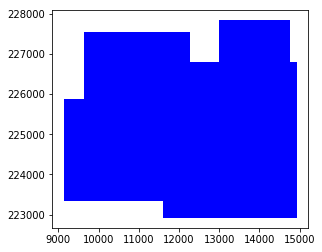

0    POLYGON ((9131.602699999698 223342.4704999998,...
dtype: object


In [0]:
from shapely.ops import unary_union

unionboulds = gpd.GeoSeries(unary_union(dfaa["geometry"]))
unionboulds.plot(color = 'blue')
plt.show()
print(unionboulds)

In [0]:
unionboulds.crs = {'init' :'epsg:3763'} 

o plot the data on a folium map, we need to convert to a Geographic coordinate system with the wgs84 datum (EPSG: 4326). We also need to greate a GeoJSON object out of the GeoDataFrame.

In [0]:
unionboulds = unionboulds.to_crs({'init': 'epsg:4326'})

In [0]:
unionboulds.plot

<bound method GeoSeries.plot of 0    POLYGON ((-8.023439550317443 41.67943736298685...
dtype: object>

### save as geojson

In [0]:
unionboulds.to_file("unionboulds.geojson", driver="GeoJSON")

### save as shp

In [0]:
unionboulds.to_file('unionboulds.shp',driver ='ESRI Shapefile')

#### Plot a boundary in WGS 84 EPSG code 4326 on a folium slipping map

In [0]:
m = folium.Map([41.826, -7.791], zoom_start=11)
boundsdata = unionboulds
folium.GeoJson(unionboulds).add_to(m)
m

#### Connect to the API using a username and password

In [0]:
user = '****' ## change this!
password = '******' ## change this!

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

footprint = geojson_to_wkt(read_geojson('/content/drive/My Drive/Buildings and Health/unionboulds.geojson'))
# search by polygon
print (footprint)

POLYGON((-8.0234 41.6794,-8.0234 41.7023,-8.0173 41.7023,-8.0173 41.7173,-7.9857 41.7172,-7.9857 41.7106,-7.9770 41.7106,-7.9770 41.7198,-7.9558 41.7198,-7.9558 41.7105,-7.9537 41.7105,-7.9538 41.6755,-7.9939 41.6756,-7.9939 41.6794,-8.0234 41.6794))


#### Search
Search for images that fall with the date range 25th Feb 2019 - 27 Feb 2019, we want sentinel 2 level2A and cloud cover of 0-10%

In [0]:
products = api.query(footprint,
                     date = ('20190501', '20190701'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

In [0]:
len(products)

5

In [0]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

title  ...                                           geometry
8f7359fb-63b5-4d18-8715-d76821f53c4c  S2B_MSIL2A_20190530T112119_N0212_R037_T29TNG_2...  ...  (POLYGON ((-7.6855774 41.45624189757688, -7.66...
b9e63db9-939f-4d3b-a9ee-1e0d8fd4dbfa  S2A_MSIL2A_20190528T113321_N0212_R080_T29TNG_2...  ...  (POLYGON ((-8.021606 41.45816151054315, -7.984...
894a5e35-e864-4a22-a170-6196f16c0a05  S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_2...  ...  (POLYGON ((-7.6855774 41.45624189757688, -7.66...
95073365-ae2c-4bea-a488-1e3be5ebbeff  S2B_MSIL2A_20190513T113329_N0212_R080_T29TNG_2...  ...  (POLYGON ((-8.034943 41.45823759629042, -8.025...
ec5df91d-7127-443c-ba61-00022d35e572  S2B_MSIL2A_20190503T113329_N0211_R080_T29TNG_2...  ...  (POLYGON ((-8.033478000000001 41.4582292630517...

[5 rows x 35 columns]

In [0]:
products_gdf_sorted['identifier']

8f7359fb-63b5-4d18-8715-d76821f53c4c    S2B_MSIL2A_20190530T112119_N0212_R037_T29TNG_2...
b9e63db9-939f-4d3b-a9ee-1e0d8fd4dbfa    S2A_MSIL2A_20190528T113321_N0212_R080_T29TNG_2...
894a5e35-e864-4a22-a170-6196f16c0a05    S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_2...
95073365-ae2c-4bea-a488-1e3be5ebbeff    S2B_MSIL2A_20190513T113329_N0212_R080_T29TNG_2...
ec5df91d-7127-443c-ba61-00022d35e572    S2B_MSIL2A_20190503T113329_N0211_R080_T29TNG_2...
Name: identifier, dtype: object

Plot the table as a GeoPandas dataframe, based on the uuid field

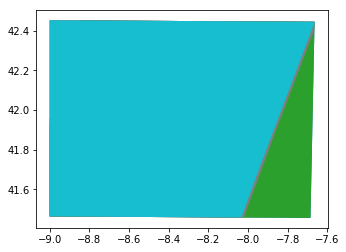

In [0]:
areas = api.to_geodataframe(products)
areas.plot(column='uuid', cmap=None)

Label these polygons

894a5e35-e864-4a22-a170-6196f16c0a05    Annotation(-8.31628, 41.9444, '894a5e35-e864-4...
8f7359fb-63b5-4d18-8715-d76821f53c4c    Annotation(-8.31915, 41.9455, '8f7359fb-63b5-4...
95073365-ae2c-4bea-a488-1e3be5ebbeff    Annotation(-8.42071, 41.9815, '95073365-ae2c-4...
b9e63db9-939f-4d3b-a9ee-1e0d8fd4dbfa    Annotation(-8.41419, 41.981, 'b9e63db9-939f-4d...
ec5df91d-7127-443c-ba61-00022d35e572    Annotation(-8.42018, 41.9815, 'ec5df91d-7127-4...
dtype: object

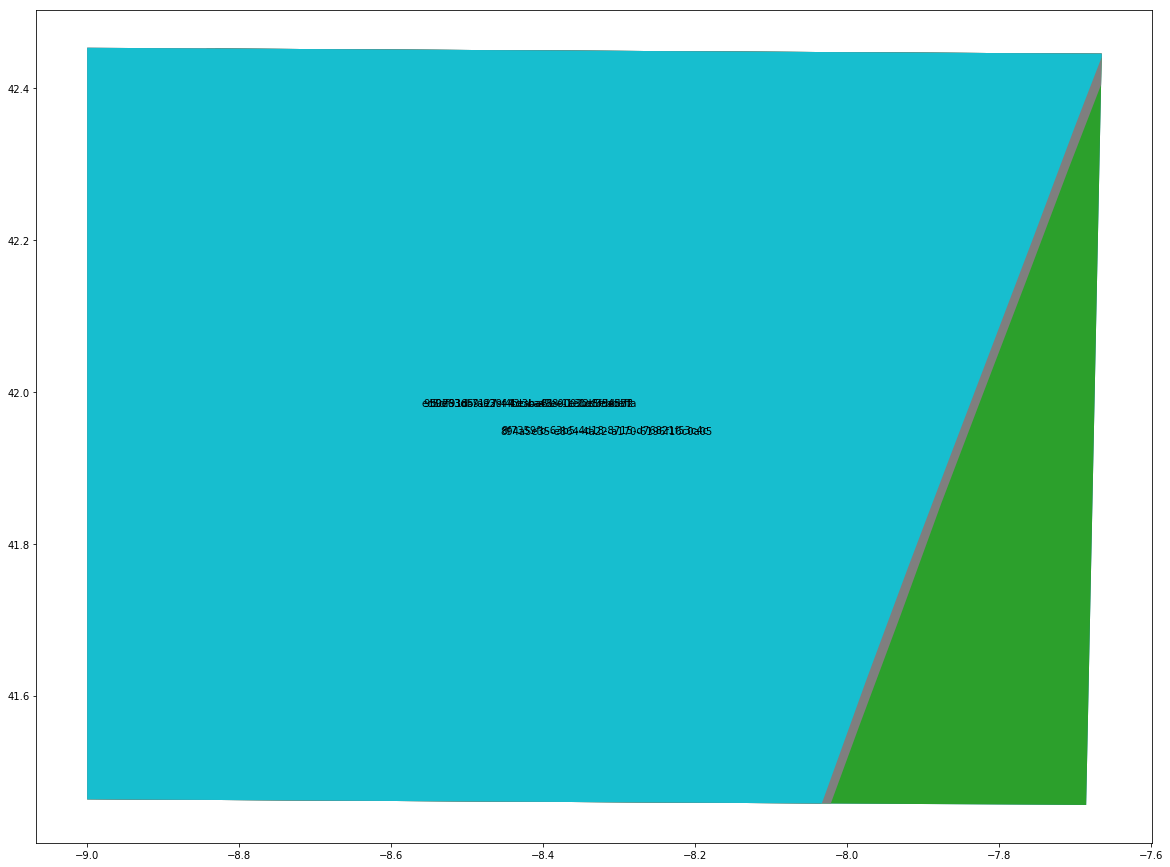

In [0]:
ax = areas.plot(column='uuid', cmap=None, figsize=(20, 20), label='uuid')
areas.apply(lambda x: ax.annotate(s=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

##### Inspect vs defined bounds
use geopandas to check which data download

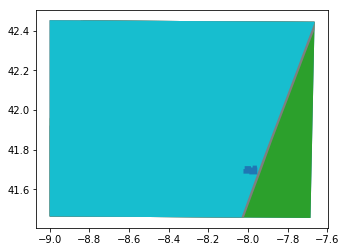

In [0]:
f, ax = plt.subplots(1)
areas.plot(ax=ax,column='uuid',cmap=None,)
unionboulds.plot(ax=ax)
plt.show()

In [0]:
api.get_product_odata('894a5e35-e864-4a22-a170-6196f16c0a05') 

{'Creation Date': datetime.datetime(2019, 5, 26, 9, 0, 59, 220000),
 'Ingestion Date': datetime.datetime(2019, 5, 26, 7, 1, 1, 878000),
 'Online': True,
 'date': datetime.datetime(2019, 5, 25, 11, 21, 21, 24000),
 'footprint': 'POLYGON((-9.000244 41.919199554346484,-8.965637 42.028997525190384,-8.919128 42.17609634022958,-8.872559 42.3231715864308,-8.831665 42.4517097340947,-7.6651 42.44491772432881,-7.6855774 41.45624189757688,-9.000244 41.463751887157464,-9.000244 41.919199554346484))',
 'id': '894a5e35-e864-4a22-a170-6196f16c0a05',
 'md5': '92E3C00B6FB30A343348AA2D7D890D3A',
 'size': 1187726247,
 'title': 'S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('894a5e35-e864-4a22-a170-6196f16c0a05')/$value"}

Download the data

In [0]:
api.download("894a5e35-e864-4a22-a170-6196f16c0a05") 

Downloading: 100%|██████████| 1.19G/1.19G [02:51<00:00, 6.92MB/s]
MD5 checksumming: 100%|██████████| 1.19G/1.19G [00:04<00:00, 286MB/s]


{'Creation Date': datetime.datetime(2019, 5, 26, 9, 0, 59, 220000),
 'Ingestion Date': datetime.datetime(2019, 5, 26, 7, 1, 1, 878000),
 'Online': True,
 'date': datetime.datetime(2019, 5, 25, 11, 21, 21, 24000),
 'downloaded_bytes': 1187726247,
 'footprint': 'POLYGON((-9.000244 41.919199554346484,-8.965637 42.028997525190384,-8.919128 42.17609634022958,-8.872559 42.3231715864308,-8.831665 42.4517097340947,-7.6651 42.44491772432881,-7.6855774 41.45624189757688,-9.000244 41.463751887157464,-9.000244 41.919199554346484))',
 'id': '894a5e35-e864-4a22-a170-6196f16c0a05',
 'md5': '92E3C00B6FB30A343348AA2D7D890D3A',
 'path': './S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.zip',
 'size': 1187726247,
 'title': 'S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('894a5e35-e864-4a22-a170-6196f16c0a05')/$value"}

unzip

In [0]:
!unzip S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.zip

Archive:  S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.zip
   creating: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/INSPIRE.xml  
   creating: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/rep_info/
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/HTML/
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/HTML/star_bg.jpg  
 extracting: S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/HTML/banner_1.png  


### Create RGB Image 
The true colour of satellite images is often displayed in a combination of red, green and blue band. 
read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

In [0]:
# Open Bands 4, 3 and 2 with Rasterio

R10 = '/content/drive/My Drive/Buildings and Health/S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/GRANULE/L2A_T29TNG_A020483_20190525T112609/IMG_DATA/R10m'

b4 = rio.open(R10+'/T29TNG_20190525T112121_B04_10m.jp2') 
b3 = rio.open(R10+'/T29TNG_20190525T112121_B03_10m.jp2')
b2 = rio.open(R10+'/T29TNG_20190525T112121_B02_10m.jp2')

In [0]:
b4.count, b4.width, b4.height, b4.crs

(1, 10980, 10980, CRS.from_epsg(32629))

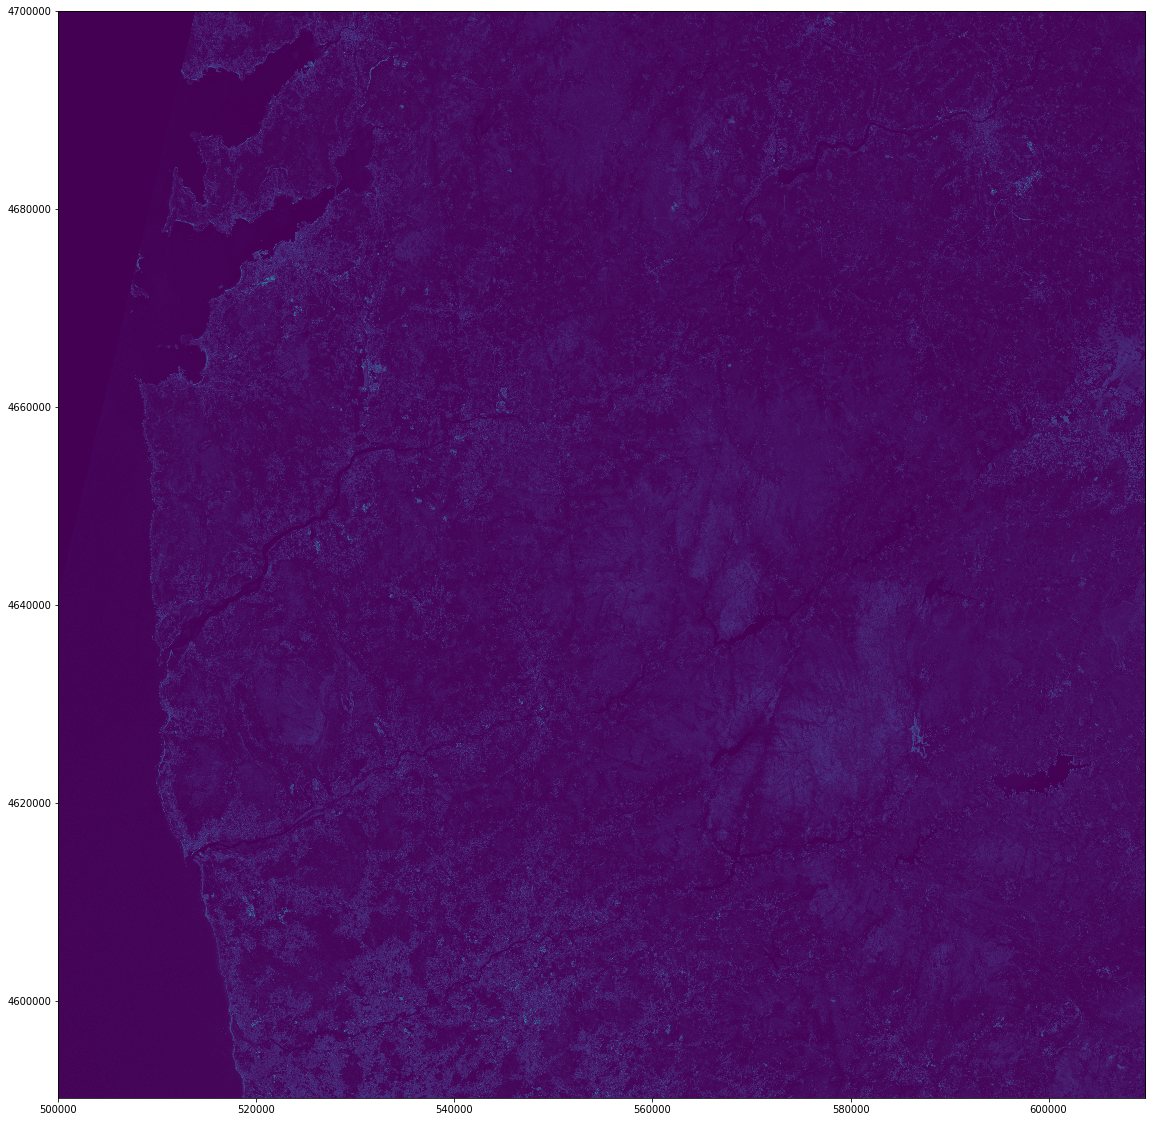

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

In [0]:
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [0]:
with rio.open('RGB.tiff') as src:
    print(src.crs)

EPSG:32629


### Mask Satellite images
One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Cabril area from the RGB image.

In [0]:
#src = rio.open(r"RGB.tiff")
#unionboulds.crs = {'init' :'epsg:3763'} 
#EPSG:32629

unionboulds = unionboulds.to_crs({'init': 'epsg:32629'})
with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, unionboulds.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [0]:
unionboulds.crs

{'init': 'epsg:32629'}

In [0]:
print(unionboulds.total_bounds)


[ 581255.97413099 4614245.11699849  587080.87921609 4619193.23116591]



Here, we first reproject our Natural reserve with the same projection as the RGB image. Next, we open the RGB image, get the metadata and mask with the projected boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


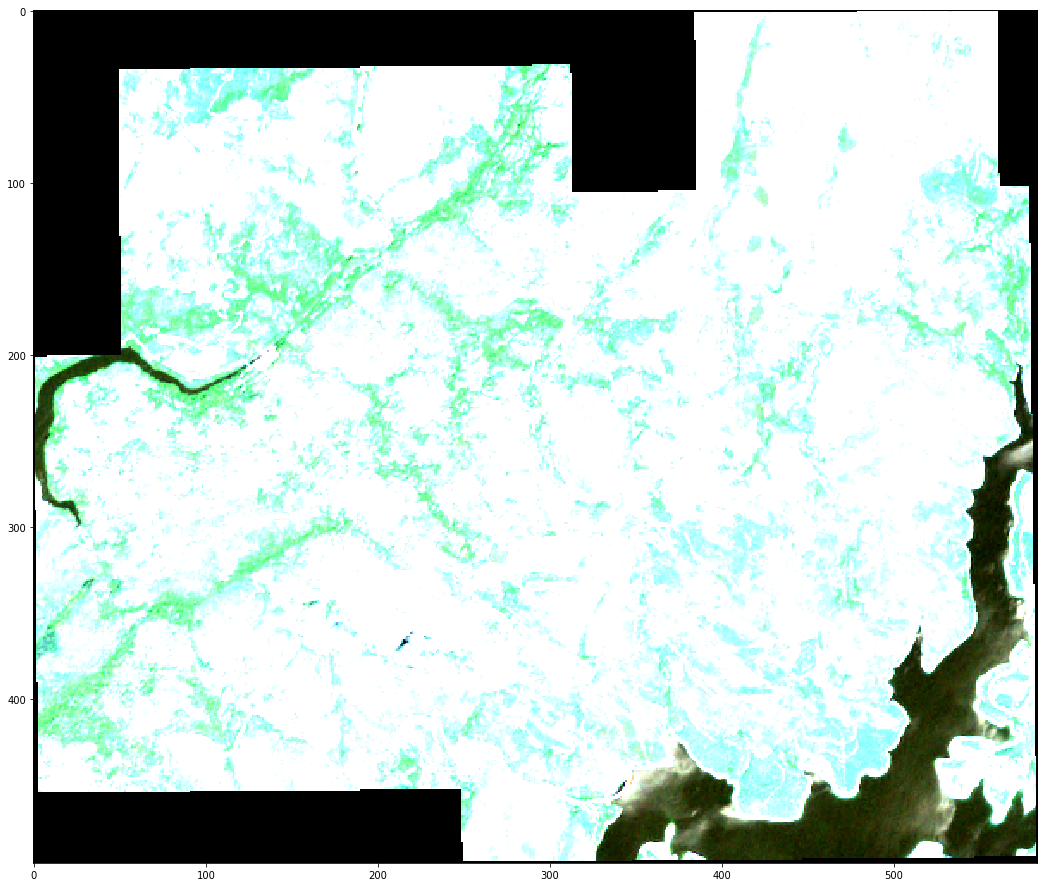

<function matplotlib.pyplot.show>

In [0]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

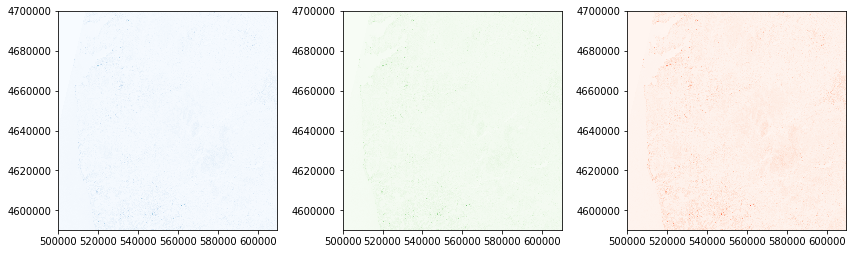

In [0]:
#multiple band representation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(b2, ax=ax1, cmap='Blues')
plot.show(b3, ax=ax2, cmap='Greens')
plot.show(b4, ax=ax3, cmap='Reds')
fig.tight_layout()

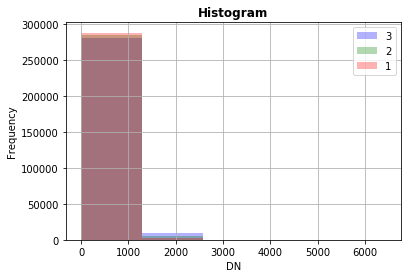

In [0]:
#generate histogram
trueColor = rasterio.open('/content/drive/My Drive/Buildings and Health/RGB_masked.tif')
plot.show_hist(trueColor, bins=5, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

In [0]:
#export false color image
falseColor = rasterio.open('/content/drive/My Drive/Buildings and Health/SentinelFalseColor.tiff', 'w', driver='Gtiff',
                          width=b2.width, height=b2.height,
                          count=3,
                          crs=b2.crs,
                          transform=b2.transform,
                          dtype='uint16'                   
                         )
falseColor.write(b3.read(1),3) #Blue
falseColor.write(b4.read(1),2) #Green
falseColor.write(b8.read(1),1) #Red
falseColor.close()

In [0]:
image_file ='/content/drive/My Drive/Buildings and Health/RGB_masked.tif'
sat_data = rasterio.open(image_file)

In [0]:
width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

Width: 5840.0, Height: 4960.0


In [0]:
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

Rows: 496, Columns: 584


In [0]:
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (581250.0, 4619200.0)
Bottom right corner coordinates: (586200.0, 4613370.0)


In [0]:
print(sat_data.count)
# sequence of band indexes
print(sat_data.indexes)

3
(1, 2, 3)


In [0]:
# Load the 4 bands into 2d arrays 
b, g, r = sat_data.read()

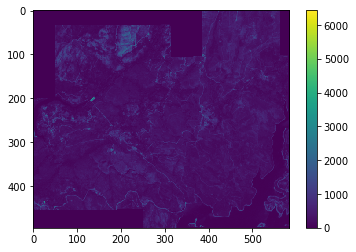

In [0]:
# Displaying the blue band.
fig = plt.imshow(b)
plt.colorbar()
plt.show()

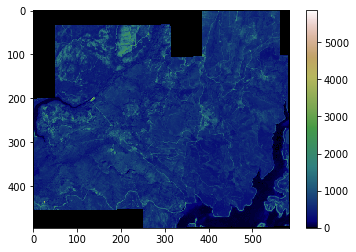

In [0]:
# Displaying the green band.
fig = plt.imshow(g)
fig.set_cmap('gist_earth')
plt.colorbar()
plt.show()

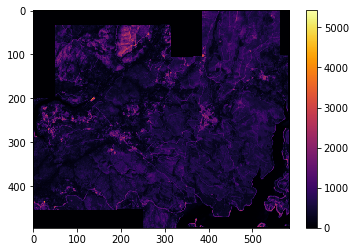

In [0]:
# Displaying the red band.

fig = plt.imshow(r)
fig.set_cmap('inferno')
plt.colorbar()
plt.show()

### NDVI
One of the most widely used index to measure vegetation is the Normalized Difference Vegetation Index (NDVI). the NDVI values range from +1.0 to -1.0. It was developed by NASA scientist Compton Tucker in 1977 and is derived from satellite imagery.

[link text](https://)Extracting the data from the red and near-infrared bands

vegetation:  (Band8-Band4)/ (Band8+Band4)

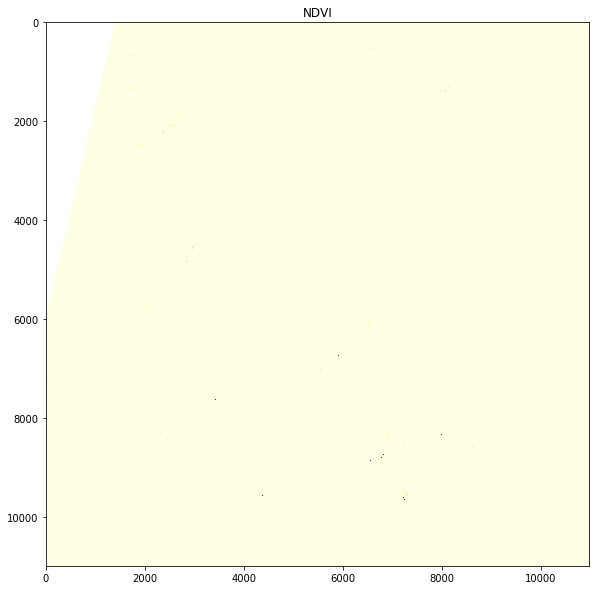

In [0]:
from osgeo import gdal
import sys

# Open up your two .tif files you'll need to do the calculation

b8 = gdal.Open('/content/drive/My Drive/Buildings and Health/S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/GRANULE/L2A_T29TNG_A020483_20190525T112609/IMG_DATA/R10m/T29TNG_20190525T112121_B08_10m.jp2')
b4 = gdal.Open('/content/drive/My Drive/Buildings and Health/S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/GRANULE/L2A_T29TNG_A020483_20190525T112609/IMG_DATA/R10m/T29TNG_20190525T112121_B04_10m.jp2')


# Do not display error when divided by zero 
np.seterr(divide='ignore', invalid='ignore')

# Just in case you somehow have a bad file you should always check to make sure the file was opened properly. Then it's time to grab the band from each .jp2 file.
d8 = b8.GetRasterBand(1)
d4 = b4.GetRasterBand(1)

# Then we need to make it readable so we'll input the data as an array.
img_8 = d8.ReadAsArray()
img_4 = d4.ReadAsArray()

# Next is the calculation remember [(NIR-RED)/(NIR+RED)]
ndvi = (img_8 - img_4) / (img_8 + img_4)

# Finally we'll set up the plot and graph the data to the screen.
# This is the full image
fig = plt.figure(figsize=(10, 10))
fig.set_facecolor('white')
plt.imshow(ndvi, cmap='YlGn') # Typically the color map for NDVI maps are the Red to Yellow to Green
plt.title('NDVI')
plt.show()


In [0]:
ndvi

array([[           nan,            nan,            nan, ...,
        8.26572747e-01, 8.34061135e-01, 7.88920726e-01],
       [           nan,            nan,            nan, ...,
        8.87874837e-01, 8.81925522e-01, 7.62412993e-01],
       [           nan,            nan,            nan, ...,
        9.06147349e-01, 8.33938294e-01, 7.47453210e-01],
       ...,
       [9.94764398e-02, 1.36659436e-01, 5.14579760e-03, ...,
        2.34256927e-01, 2.16562245e-01, 3.31914894e-01],
       [1.30541833e+02, 1.23033835e+02, 1.36126819e+02, ...,
        1.59493671e-01, 1.70028818e-01, 1.86210794e-01],
       [1.43539474e+02, 1.85977273e+02, 1.94311573e+02, ...,
        2.00208551e-01, 2.86503552e-01, 2.30945559e-01]])

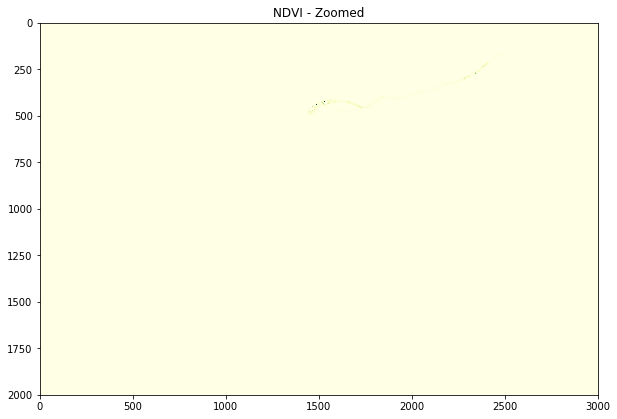

In [0]:
# zoom in on a specific area, by adjusting what part of the array is plotted
# Compare it to the one from the previous image. You can adjust the range to specify the amount that it is zoomed in. Remember that the ndvi array is [y,x] and not [x,y] like we might normally think.
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
plt.imshow(ndvi[8000:10000, 0:3000], cmap='YlGn')
plt.title('NDVI - Zoomed')
plt.show()

Checking the range of NDVI values(excluding NaN)
Let's print the minimum and maximum values in our calculated ndvi. Because we're using the NDVI formula to normalize the input bands, we know that our expected values should fall within -1.0 to +1.0.

In [65]:
print(np.nanmin(ndvi)) 
print(np.nanmax(ndvi))

0.0
65535.0


##### Saving the NDVI image
We will save the results to a new single band image. This new image file will use the geospatial data rom the original geotiff image.

In [0]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

Final save the result to a bew geotiff

### Normalized Difference Water Index (NDWI)
NDWI =   (Band4-Band3)/ (Band4+Band3)

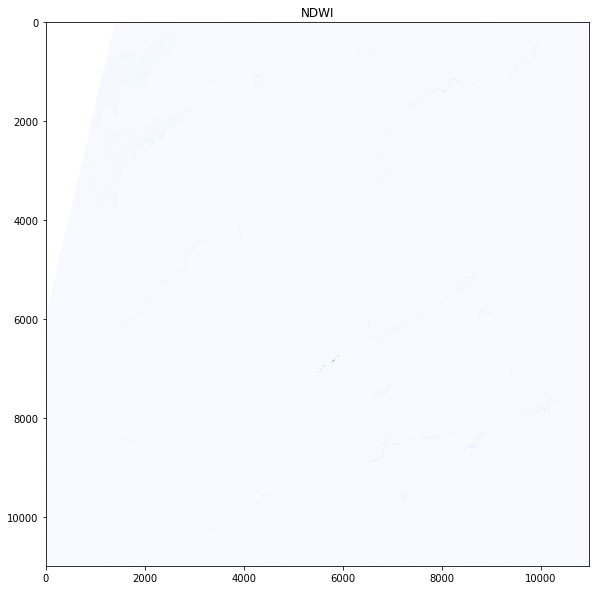

In [66]:
# Open up your two .tif files you'll need to do the calculation

b3 = gdal.Open('/content/drive/My Drive/Buildings and Health/S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/GRANULE/L2A_T29TNG_A020483_20190525T112609/IMG_DATA/R10m/T29TNG_20190525T112121_B03_10m.jp2')
b4 = gdal.Open('/content/drive/My Drive/Buildings and Health/S2A_MSIL2A_20190525T112121_N0212_R037_T29TNG_20190525T193310.SAFE/GRANULE/L2A_T29TNG_A020483_20190525T112609/IMG_DATA/R10m/T29TNG_20190525T112121_B04_10m.jp2')


# Do not display error when divided by zero 
np.seterr(divide='ignore', invalid='ignore')

# Just in case you somehow have a bad file you should always check to make sure the file was opened properly. Then it's time to grab the band from each .jp2 file.
d3 = b3.GetRasterBand(1)
d4 = b4.GetRasterBand(1)

# Then we need to make it readable so we'll input the data as an array.
img_3 = d3.ReadAsArray()
img_4 = d4.ReadAsArray()

# Next is the calculation remember [(NIR-RED)/(NIR+RED)]
ndwi = (img_4 - img_3) / (img_4 + img_3)

# Finally we'll set up the plot and graph the data to the screen.
# This is the full image
fig = plt.figure(figsize=(10, 10))
fig.set_facecolor('white')
plt.imshow(ndwi, cmap='Blues') # Typically the color map for NDVI maps are the Red to Yellow to Green
plt.title('NDWI')
plt.show()

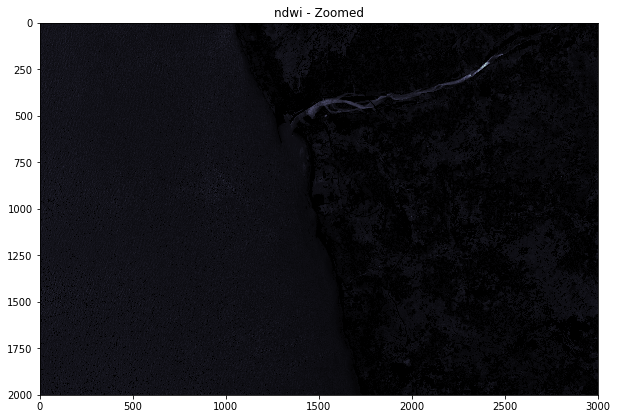

In [0]:
# zoom in on a specific area, by adjusting what part of the array is plotted
# Compare it to the one from the previous image. You can adjust the range to specify the amount that it is zoomed in. Remember that the ndvi array is [y,x] and not [x,y] like we might normally think.
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
plt.imshow(ndwi[8000:10000, 0:3000], cmap='bone')
plt.title('ndwi - Zoomed')
plt.show()

#### unsupervised classification

In [0]:
from sklearn import cluster
from osgeo import gdal, gdal_array

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open('/content/drive/My Drive/Buildings and Health/RGB_masked.tif', gdal.GA_ReadOnly)


band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

(496, 584)
(289664, 1)
496


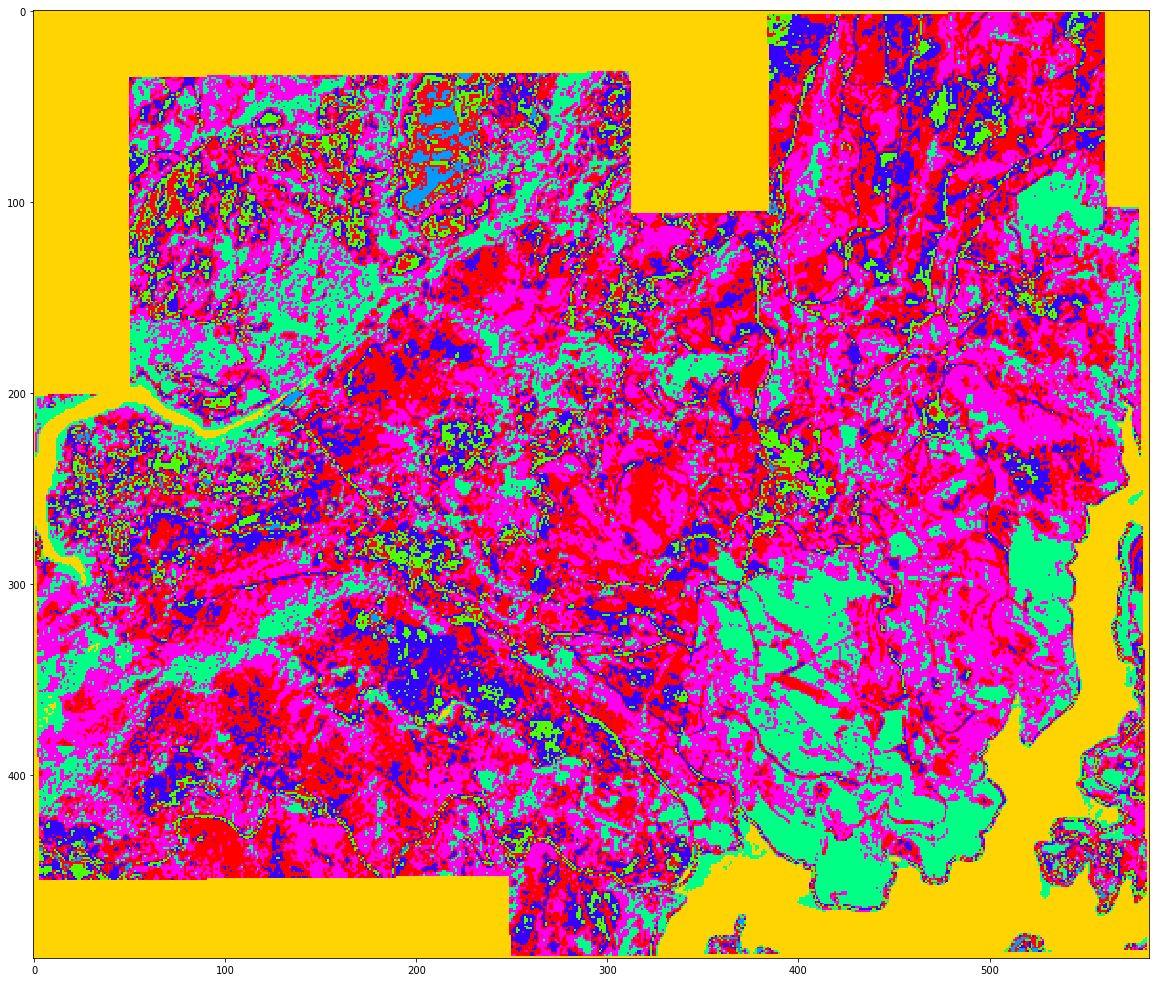

In [0]:
%matplotlib inline  

import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

### Land Use/Land Cover (LULC) classification with Deep Learning
This a mini-project to classify 9 Land use classes using transfer learning in Convolutional Neural Networks (CNN). The Dataset used in this project is published with the original paper tittled: EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification.

EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification" https://arxiv.org/abs/1709.00029 (https://github.com/phelber/eurosat)




In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.plots import *

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

In [0]:
PATH = Path('/home/shakur/GeoProjects/EuroSat/Bands/')
train_path = PATH/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

### Visualization
### Classes and Size

In [0]:
files = []

for i in classes:
    paths =train_path/i
    files.append(list(paths.iterdir())[0])
classes_num = {}
for i in classes:
   
    folders = train_path/i
    classes_num[i] = len(list(folders.iterdir()))
    #print(f'{i} class has {len(list(folders.iterdir()))}')
plt.figure(figsize=(15,6))
plt.bar(classes_num.keys(), classes_num.values(), color='green')
plt.title('Land Use Classes & Size', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig('classes.jpg')

In [0]:
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(331);plt.axis('off');plot.show((rasterio.open(files[0])), ax=ax1, title=classes[0])
ax2 = plt.subplot(332);plt.axis('off');plot.show((rasterio.open(files[1])), ax=ax2, title=classes[1])
ax3 = plt.subplot(333);plt.axis('off');plot.show((rasterio.open(files[2])), ax=ax3, title=classes[2])

ax1 = plt.subplot(334);plt.axis('off');plot.show((rasterio.open(files[3])), ax=ax1, title=classes[3])
ax2 = plt.subplot(335);plt.axis('off');plot.show((rasterio.open(files[4])), ax=ax2, title=classes[4])
ax3 = plt.subplot(336);plt.axis('off');plot.show((rasterio.open(files[5])), ax=ax3, title=classes[5])

ax1 = plt.subplot(337);plt.axis('off');plot.show((rasterio.open(files[6])), ax=ax1, title=classes[6])
ax2 = plt.subplot(338);plt.axis('off');plot.show((rasterio.open(files[7])), ax=ax2, title=classes[7])
ax3 = plt.subplot(339);plt.axis('off');plot.show((rasterio.open(files[8])), ax=ax3, title=classes[8])

plt.tight_layout()


### Model

In [0]:
sz = 224
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
learn.fit(0.001, 2)

In [0]:
lrf=learn.lr_find(start_lr=1e-5, end_lr=1e-1)

In [0]:
learn.sched.plot_lr()


In [0]:
learn.sched.plot()

In [0]:
learn.fit(1e-5, 3, cycle_len=1)

In [0]:
learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2)


In [0]:
learn.precompute = False 
learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2)

In [0]:
lr = 1e-4
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

### Analyzing results & Visualization

In [0]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [0]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
preds

In [0]:
data.val_ds.fnames[0]

### Invidual Predictions

In [0]:
classes_dict = dict(enumerate(data.classes))
classes_dict

In [0]:
fn = data.val_ds.fnames[0]
pic1 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic1)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'AnnualCrop')
np.argmax(preds), classes_dict[np.argmax(preds)]


In [0]:
data.val_ds.fnames[2900]

In [0]:
fn = data.val_ds.fnames[2900]
pic2 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic2)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([2900]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'Pasture')
np.argmax(preds), classes_dict[np.argmax(preds)]

### Confusion Matrix

In [0]:
multi_preds = learn.predict()
preds = np.argmax(multi_preds, axis=1)
preds

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes, cmap='Reds',figsize=(12,6))
plt.tight_layout()